Reference: https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2


In [213]:
#build a topic model using Gensim LDA and visualise the topics using pyLDAvis and create a word cloud for each topic

import re
import pandas as pd
import numpy as np
import os
import pprint
import pickle

#Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['irish'])

import spacy

import pyLDAvis 
import pyLDAvis.gensim_models

import seaborn as sns 
sns.set()

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)





In [214]:
#load in the data 
df = pd.read_csv('bushranger_kwics_with_50_word_window.csv')
#convert key words in context into list of strings
data = list(df.kwic)


Build the bigram and trigrams

In [215]:
# Build the bigram and trigrams
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

define a function for preprocessing:

In [216]:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk library
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [217]:
# call the function, The output of data_ready is a list containing list of strings for each document 
data_ready = process_words(data)

Create the Dictionary and Corpus:
The model requires a dictionary and a corpus to process. Dictionary contains all the words and numerical identifiers one for each unique word. On the other hand, corpus is a list of lists containing tuples for each word id and its frequency.

In [218]:
#create dictionary and get the length of vocabulary:
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 11857


In [219]:
#create corpus:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [220]:
#create a dictionary to display word frequency
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/var/folders/v8/16yc7hy13dn8gqzv70qdbg1h0000gn/T/ipykernel_86557/3355411391.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dict_df['freq'], bins=100);


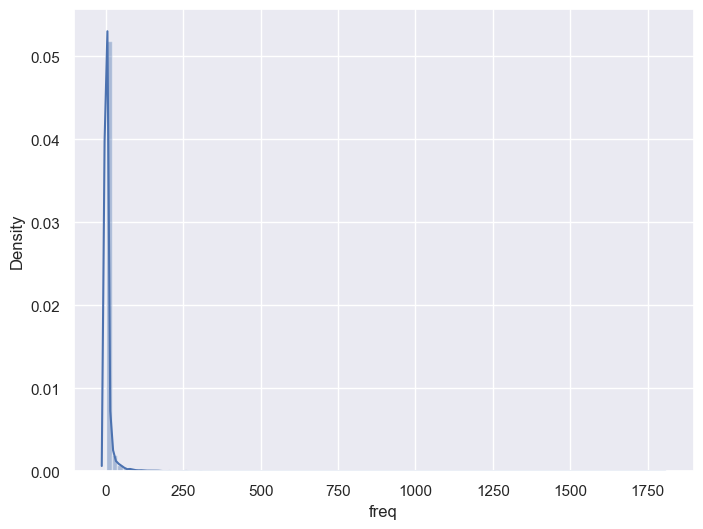

In [221]:
#make a histogram that shows word frequencies to better understand the corpus
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [222]:
#display top 10 most frequent words
dict_df.sort_values(by='freq', ascending=False).head(10)


,freq
bushranger,1793
say,1043
man,859
see,549
take,506
make,454
bushrang,441
come,395
know,385
time,358


Exclude high frequency words from dictionary. Ammend this based on dataset

In [223]:
extension = dict_df[dict_df.freq>1000].index.tolist()
#established at 2000 for irish dataset and 1000 for bushranger dataset

In [224]:
# add high frequency words to stop words list
stop_words.extend(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 11803


Filter out words that occur less than 10 documents, or more than 70% of the documents.

In [225]:

id2word.filter_extremes(no_below=10, no_above=0.7) #change no_above to change threshold
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 1448


In [226]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [227]:
install the mallett package
!python -m wget https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [228]:
!unzip mallet-2.0.8.zip

In [229]:
import os

In [230]:
#get the file path to the mallet package 
current_file_path = os.path.abspath(os.path.dirname('__file__'))
mallet_path = os.path.join(current_file_path, 'mallet-2.0.8', 'bin', 'mallet')




In [231]:
from gensim.models.wrappers import LdaMallet


specify the number of topics in advance.

In [232]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=40, id2word=id2word) #change num_topics here

Mallet LDA: 40 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 39
total tokens: 45731
<10> LL/token: -8.81632
<20> LL/token: -8.04184
<30> LL/token: -7.72441
<40> LL/token: -7.58337

0	1.25	constable brother mile man hold strange fall command quick bullet direction circumstance yard hut fail rock barrow movement hit honest 
1	1.25	continue eye point strike draw life dog outlaw dare smile lay opposite stick purpose invite curse tlie bore bis sneak 
2	1.25	follow long captain money evening hear foot late effect trouble hair shadow fresh blood intention reveal thin apparently news bad 
3	1.25	make lead expect walk fact side order week house letter gather forget secure emotion history colony engage advantage put daughter 
4	1.25	give reply law friend state surprise talk growl surrender nay man fire force remain understand sudden hear show gardiner trap 
5	1.25	horse man low kill mind sight fly big constable saddle half master sit excitement speed pursuit anxious stable sha

In [233]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(32,
  [('husband', 0.06045156591405681),
   ('davy', 0.04661325564457393),
   ('bed', 0.041514930808448654),
   ('lip', 0.03641660597232338),
   ('hand', 0.02986161689730517),
   ('glance', 0.025491624180626365),
   ('utter', 0.023306627822286964),
   ('honest', 0.02039329934450109),
   ('bag', 0.018936635105608158),
   ('add', 0.01747997086671522)]),
 (5,
  [('horse', 0.19458544839255498),
   ('trooper', 0.08460236886632826),
   ('put', 0.06683587140439932),
   ('wait', 0.03637901861252115),
   ('saddle', 0.03637901861252115),
   ('mount', 0.03468697123519458),
   ('shout', 0.032148900169204735),
   ('rein', 0.031302876480541454),
   ('gallop', 0.02707275803722504),
   ('figure', 0.023688663282571912)]),
 (3,
  [('leave', 0.06448763250883392),
   ('horse', 0.030918727915194347),
   ('man', 0.030918727915194347),
   ('aware', 0.029151943462897525),
   ('call', 0.028268551236749116),
   ('day', 0.028268551236749116),
   ('spot', 0.027385159010600707),
   ('bring', 0.026501766784452298

In [234]:
#save the model as a pickle file to load in later for analysis
import pickle
pickle.dump(ldamallet, open('ldamallet_bushranger_40_topics.pkl', 'wb'))

In [235]:
#load the model
ldamallet = pickle.load(open('ldamallet_bushranger_40_topics.pkl', 'rb'))


get the topic modeling results (distribution of topics for each document) by passing in the corpus to the model.

In [236]:
tm_results = ldamallet[corpus]

In [237]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

To get most probable words for the given topicid, we can use show_topic() method. It returns sequence of probable words, as a list of (word, word_probability) for specific topic. You can get top 20 significant terms and their probabilities for each topic as below:

In [238]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

display all the terms for a topic in a single row

In [239]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df


/var/folders/v8/16yc7hy13dn8gqzv70qdbg1h0000gn/T/ipykernel_86557/700813777.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"man, make, constable, brother, return, chief, tion, search, circumstance, party, strange, sentence, death, mind, work, barrow, honest, father, fail, hold"
Topic2,"continue, chapter, man, eye, stick, dog, tie, flash, brother, speak, life, bear, listen, family, author, read, room, curse, hate, coward"
Topic3,"hear, captain, door, hour, kate, trouble, waa, close, anxious, danger, place, doubt, open, window, kill, knock, fellow, shake, rid, lieutenant"
Topic4,"leave, horse, man, aware, day, call, spot, bring, gather, secure, half, history, character, house, daughter, eat, make, walk, difficulty, warm"
Topic5,"fire, draw, make, hand, case, shot, give, poor, form, chance, advantage, effect, full, order, hold, show, harm, gun, tear, surprise"
Topic6,"horse, trooper, put, wait, saddle, mount, shout, rein, gallop, figure, close, change, speed, fear, evidently, sit, track, oath, hurriedly, walker"
Topic7,"capture, black, matter, young, face, laugh, wear, receive, hand, intend, feature, convey, discover, explain, officer, clothe, promise, hunt, coarse, firearm"
Topic8,"night, feel, send, lead, ill, large, secure, learn, time, mountain, attack, yard, robber, term, expedition, mutter, corporal, fear, ment, molly"
Topic9,"place, leave, wound, charge, party, head, prisoner, safe, deep, return, steal, hear, body, examine, bind, soldier, nature, spot, brave, break"
Topic10,"strike, enter, small, find, point, reach, water, coast, line, thought, constable, shelter, opposite, row, boat, possess, outlaw, invite, sleep, notice"


In [240]:
#write topics_df to csv file
topics_df.to_csv('topics_df_bushranger_40_topics.csv')

Visualize the terms as wordclouds is also a good option to present topics. Below we create wordclouds for each topic. The font sizes of words show their relative weights in the topic.

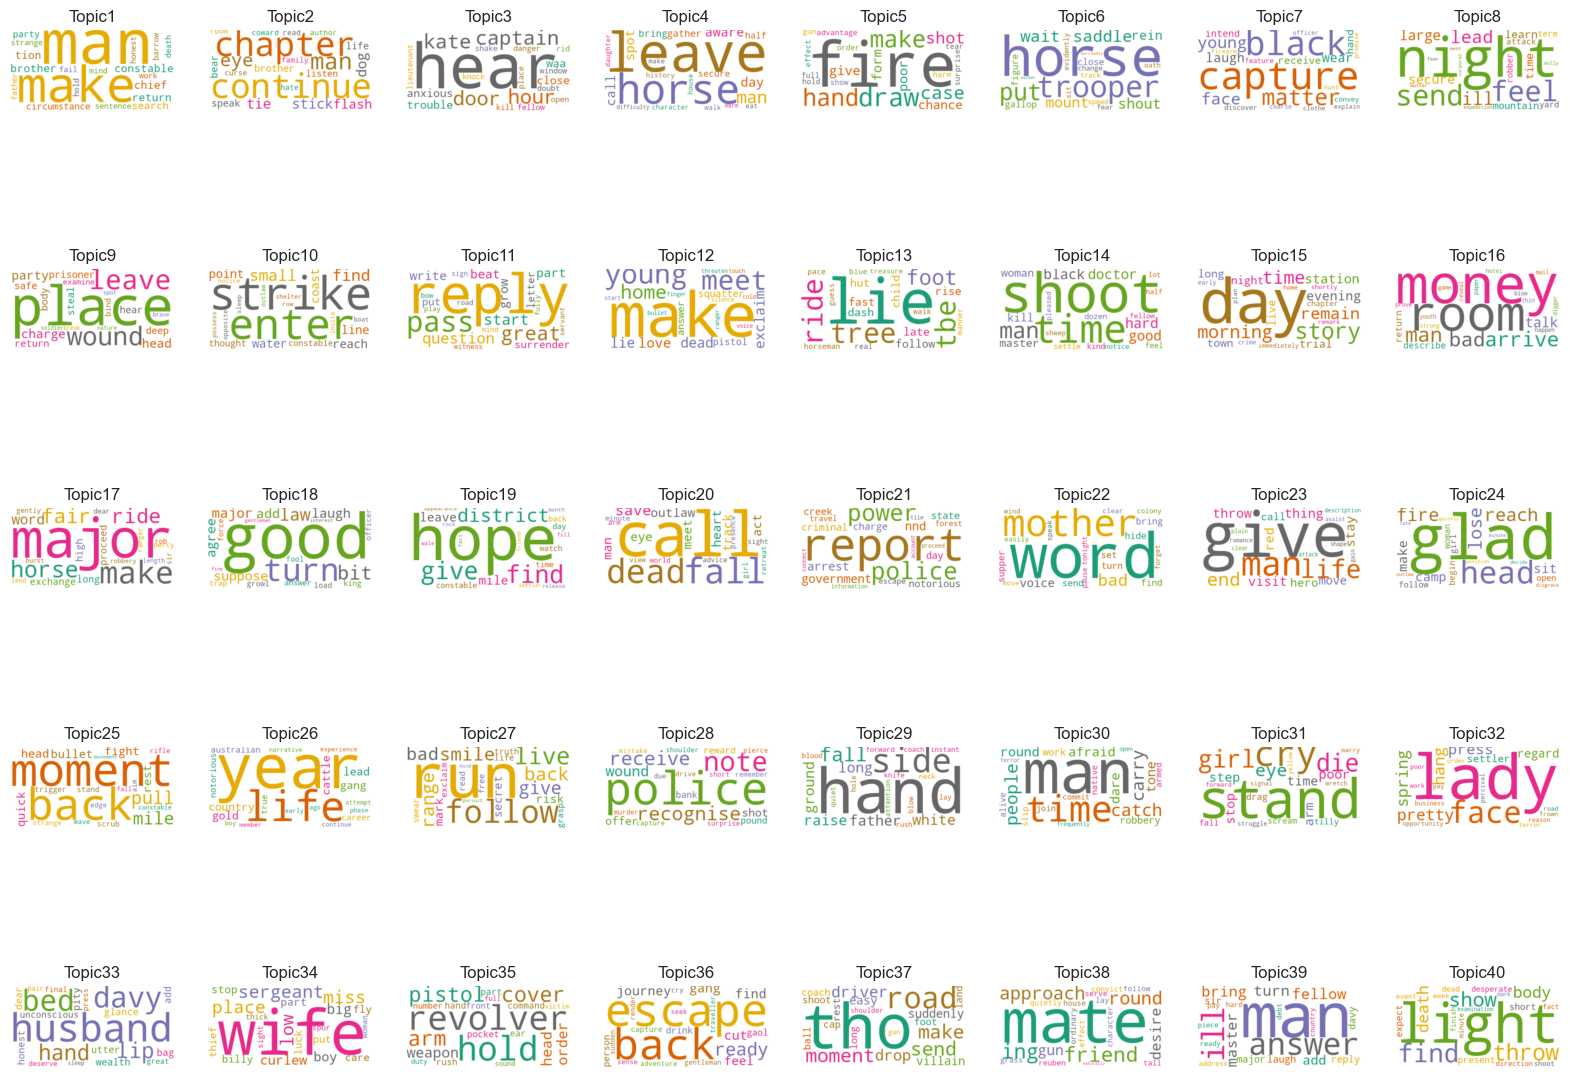

In [241]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic 
for i in range(40): #change this number dependent on no. of topics

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 8, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [242]:
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [243]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [244]:
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/Users/fiannualamorgan/anaconda3/envs/irish_topic_model/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/fiannualamorgan/anaconda3/envs/irish_topic_model/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/fiannualamorgan/anaconda3/envs/irish_topic_model/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/fiannualamorgan/anaconda3/envs/irish_topic_model/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

create a dataframe that shows dominant topic for each document and its percentage in the document.

In [245]:
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['Trove_ID'] = df.trove_id
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

,Trove_ID,Dominant Topic,Contribution %,Topic Terms
0,16,1,5.51,"man, make, constable, brother, return, chief, tion, search, circumstance, party, strange, sentence, death, mind, work, barrow, honest, father, fail, hold"
1,17,1,3.87,"man, make, constable, brother, return, chief, tion, search, circumstance, party, strange, sentence, death, mind, work, barrow, honest, father, fail, hold"
2,71,38,4.62,"mate, ing, friend, approach, round, gun, desire, quietly, convict, ordinary, serve, character, reuben, tall, grass, house, follow, effect, lay, naturally"
3,131,28,9.84,"police, note, recognise, receive, wound, offer, shot, reward, pound, bank, capture, remember, murder, mistake, shoulder, surprise, drive, due, pierce, short"
4,132,28,9.33,"police, note, recognise, receive, wound, offer, shot, reward, pound, bank, capture, remember, murder, mistake, shoulder, surprise, drive, due, pierce, short"


In [246]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)
#write to csv file 
corpus_topic_df.to_csv('Topic_in_Doc_bushranger_40_Topics.csv', index=False)
